In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
import seaborn as sns
sns.set('notebook')
import random
import pickle

from sklearn.manifold import TSNE

import torch
from torch import nn, optim, einsum
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
import os

from einops import rearrange, repeat
from einops.layers.torch import Rearrange


c:\Users\kenne\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

metadata_path = 'data/meta'
metadata = unpickle(metadata_path)
superclass_dict = dict(list(enumerate(metadata[b'coarse_label_names'])))

data_pre_path = 'data/'

# File paths
data_train_path = data_pre_path + 'train'
data_test_path = data_pre_path + 'test'
# Read dictionary
data_train_dict = unpickle(data_train_path)
data_test_dict = unpickle(data_test_path)
# Get data (change the coarse_labels if you want to use the 100 classes)
X_train = pd.DataFrame(data_train_dict[b'data'])
y_train = pd.DataFrame(np.array(data_train_dict[b'fine_labels']))
y_train_coarse = pd.DataFrame(np.array(data_train_dict[b'coarse_labels']))
X_test = pd.DataFrame(data_test_dict[b'data'])
y_test = pd.DataFrame(np.array(data_test_dict[b'fine_labels']))
y_test_coarse = pd.DataFrame(np.array(data_test_dict[b'coarse_labels']))

classes = np.array(list(map(lambda x: x.decode('utf-8'), metadata[b'fine_label_names'])))
coarse_classes = np.array(list(map(lambda x: x.decode('utf-8'), metadata[b'coarse_label_names'])))


In [3]:
temp = np.transpose(X_train.values.reshape((-1, 3, 32, 32)), axes=[0,2,3,1])
X_train = pd.DataFrame(X_train.values.reshape(-1, 3072))

temp = np.transpose(X_test.values.reshape((-1, 3, 32, 32)), axes=[0,2,3,1])
X_test = pd.DataFrame(X_test.values.reshape(-1, 3072))


In [4]:
def loc_data(data, loc):
	datacopy = copy.deepcopy(data)
	arr = np.array(datacopy.loc[loc].drop('label'))
	label = datacopy.loc[loc]['label']
	root = int(len(arr) ** 0.5)
	arr.resize((root, root))
	return label, arr

def imshow(arr: list, label: list = None, figsize=None, shape = (32, 32, 3), is_int = None):
	if is_int == None:
		if type(arr[0]) == torch.Tensor:
			is_int = (arr[0].detach().cpu().numpy() > 1).sum() > 0
		else:
			is_int = (arr[0] > 1).sum() > 0
	if label == None:
		label = [''] * len(arr)

	height = int(len(arr) ** 0.5)
	width = math.ceil(len(arr) / height)

	if figsize == None:
		fig = plt.figure()
	else:
		fig = plt.figure(figsize=figsize)
	for i in range(height):
		for j in range(width):
			ax = fig.add_subplot(height, width, i * height + j + 1)
			ax.grid(False)
			ax.set_xticks([])
			ax.set_yticks([])
			show = arr[i * height + j]
			if type(arr[i * height + j]) != torch.Tensor:
				show = torch.Tensor(show)
				# ax.imshow((arr[i * height + j].squeeze(0).cpu().permute(1, 2, 0) / 255).type(torch.uint8 if is_int else float))
			# if (show.shape[0] == 1):
			# 	ax.imshow((show.squeeze(0).cpu()).type(torch.uint8 if is_int else torch.float), cmap='gray')
			# else:
			if len(show.squeeze(0).cpu().shape) == 2:
				ax.imshow((show.squeeze(0).detach().cpu()).type(torch.uint8 if is_int else torch.float), cmap='gray')
			else:
				ax.imshow((show.squeeze(0).detach().cpu().permute(1,2,0)).type(torch.uint8 if is_int else torch.float))
			ax.set_title(label[i * height + j])

def df_to_tensor(df, shape = (28, 28)):
	return torch.tensor(df.values.reshape((-1, *shape)), dtype=torch.float32)

def preprocess(df):
	return df.copy() / 255

def mse(t1, t2, shape=(28, 28)):
	loss = nn.MSELoss(reduction='none')
	loss_result = torch.sum(loss(t1, t2), dim=2)
	loss_result = torch.sum(loss_result, dim=2)
	loss_result = loss_result / np.prod([*shape])
	return loss_result


In [5]:
def to_prob_dist(labels: torch.tensor, size = 100):
	arr = np.full((len(labels), size), 0)
	for i, label in enumerate(labels):
		arr[i][int(label.item())] = 1
	return torch.tensor(arr, dtype=torch.float32)

class TorchDataset(torch.utils.data.Dataset):
	def __init__(self, X, y, X_shape = (3, 32, 32), y_shape = (1, ), y_size = 100, transform = None):
		if (type(X) == torch.Tensor):
			self.x = X
		else:
			self.x = df_to_tensor(X, X_shape)

		self.transform = transform
            
		if (type(y) == torch.Tensor):
			self.y = y
		else:
			self.y = df_to_tensor(y, y_shape)
			self.y = to_prob_dist(self.y, y_size)

		# Transform labels to probability distributions
	
	def __len__(self):
		return len(self.y)

	def __getitem__(self, idx):
		if torch.is_tensor(idx):
			idx = idx.tolist()

		selected = self.x[idx]
            
		if self.transform:
			selected = self.transform(selected)
        
		return selected, self.y[idx]


In [6]:
train_data = TorchDataset(X_train, y_train)

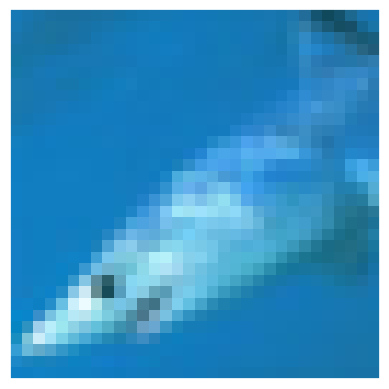

In [10]:
imshow([train_data.x[50]])

In [ ]:
imshow([train_data.x[50]])